In [1]:
# Notebook setup
%load_ext autoreload
%autoreload 2
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
# Imports
import os
import os.path as op
import logging
import mne
import numpy as np
from cerebra_atlas_python.mni_average import MNIAverage
from cerebra_atlas_python.utils import inspect_img,setup_logging,get_volume_ras

In [4]:
## Constants

# Datasets
ICBM_DIR = op.join(os.getenv("DATASETS_DIR"),"ICBM_2009c_Nonlinear_Symmetric/mni_icbm152_nlin_sym_09c_nifti")
CEREBRA_DIR = op.join(os.getenv("DATASETS_DIR"),"Cerebra")

# FreeSurfer
FS_SUBJECTS_DIR = os.getenv("SUBJECTS_DIR")
NEW_SUBJECT_NAME = "icbm152" # Used by FreeSurfer
NEW_FS_SUBJECT_DIR = op.join(FS_SUBJECTS_DIR,NEW_SUBJECT_NAME)
BEM_DIR = op.join(NEW_FS_SUBJECT_DIR, "bem")

# Output dir
CEREBRA_DATA_DIR = "../cerebra_atlas_python/cerebra_data"
CEREBRA_DATA_FS_DIR = op.join(CEREBRA_DATA_DIR, "FreeSurfer")
CEREBRA_DATA_ICBM152_DIR = op.join(CEREBRA_DATA_FS_DIR, "subjects", NEW_SUBJECT_NAME)
CEREBRA_DATA_MNE_DIR = op.join(CEREBRA_DATA_DIR, "MNE")
# HEAD_MRI_T_PATH = op.join(CEREBRA_DATA_icbm152_DIR,"head_mri_t.fif")
# FIDUCIALS_PATH = op.join(CEREBRA_DATA_icbm152_DIR,"bem/icbm152-fiducials.fif")
CEREBRA_VOLUME_PATH = op.join(CEREBRA_DATA_DIR,"volume.npy")
CEREBRA_AFFINE_PATH = op.join(CEREBRA_DATA_DIR,"affine.npy")
LABEL_DETAILS_PATH = op.join(CEREBRA_DATA_DIR,"label_details.csv")
# INFO_PATH = op.join(CEREBRA_DATA_DIR,"info.fif")
# MRI_RAS_T_PATH = op.join(CEREBRA_DATA_DIR,"mri_ras-trans.fif")
# MONTAGE_KIND = "GSN-HydroCel-129" TODO: DELETE
# MONTAGE_HEAD_SIZE = 0.1025 TODO: DELETE

In [25]:
from gzip import GzipFile
from mne.transforms import Transform, combine_transforms, invert_transform

def _get_mgz_header(fname):
    """Adapted from nibabel to quickly extract header info."""
    if not fname.endswith(".mgz"):
        raise OSError("Filename must end with .mgz")
    header_dtd = [
        ("version", ">i4"),
        ("dims", ">i4", (4,)),
        ("type", ">i4"),
        ("dof", ">i4"),
        ("goodRASFlag", ">i2"),
        ("delta", ">f4", (3,)),
        ("Mdc", ">f4", (3, 3)),
        ("Pxyz_c", ">f4", (3,)),
    ]
    header_dtype = np.dtype(header_dtd)
    with GzipFile(fname, "rb") as fid:
        hdr_str = fid.read(header_dtype.itemsize)
    header = np.ndarray(shape=(), dtype=header_dtype, buffer=hdr_str)
    # dims
    dims = header["dims"].astype(int)
    dims = dims[:3] if len(dims) == 4 else dims
    # vox2ras_tkr
    delta = header["delta"]
    ds = np.array(delta, float)
    ns = np.array(dims * ds) / 2.0
    v2rtkr = np.array(
        [
            [-ds[0], 0, 0, ns[0]],
            [0, 0, ds[2], -ns[2]],
            [0, -ds[1], 0, ns[1]],
            [0, 0, 0, 1],
        ],
        dtype=np.float32,
    )
    # ras2vox
    d = np.diag(delta)
    pcrs_c = dims / 2.0
    Mdc = header["Mdc"].T
    pxyz_0 = header["Pxyz_c"] - np.dot(Mdc, np.dot(d, pcrs_c))
    M = np.eye(4, 4)
    M[0:3, 0:3] = np.dot(Mdc, d)
    M[0:3, 3] = pxyz_0.T
    header = dict(dims=dims, vox2ras_tkr=v2rtkr, vox2ras=M, zooms=header["delta"])
    return header


def read_mri_info(path, units="m"):
    hdr = _get_mgz_header(path)
    n_orig = hdr["vox2ras"]
    t_orig = hdr["vox2ras_tkr"]
    dims = hdr["dims"]
    zooms = hdr["zooms"]

    # extract the MRI_VOXEL to RAS (non-zero origin) transform
    vox_ras_t = Transform("mri_voxel", "ras", n_orig)

    # extract the MRI_VOXEL to MRI transform
    vox_mri_t = Transform("mri_voxel", "mri", t_orig)

    # construct the MRI to RAS (non-zero origin) transform
    mri_ras_t = combine_transforms(invert_transform(vox_mri_t), vox_ras_t, "mri", "ras")

    assert units in ("m", "mm")
    if units == "m":
        conv = np.array([[1e-3, 1e-3, 1e-3, 1]]).T
        # scaling and translation terms
        vox_ras_t["trans"] *= conv
        vox_mri_t["trans"] *= conv
        # just the translation term
        mri_ras_t["trans"][:, 3:4] *= conv

    return (vox_ras_t, vox_mri_t, mri_ras_t, dims, zooms)


In [28]:
vox_ras_t, vox_mri_t, mri_ras_t, dims, zooms = read_mri_info(f"{CEREBRA_DATA_ICBM152_DIR}/mri/T1.mgz")

(<nibabel.freesurfer.mghformat.MGHImage at 0x7b87cd7356d0>,
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0.

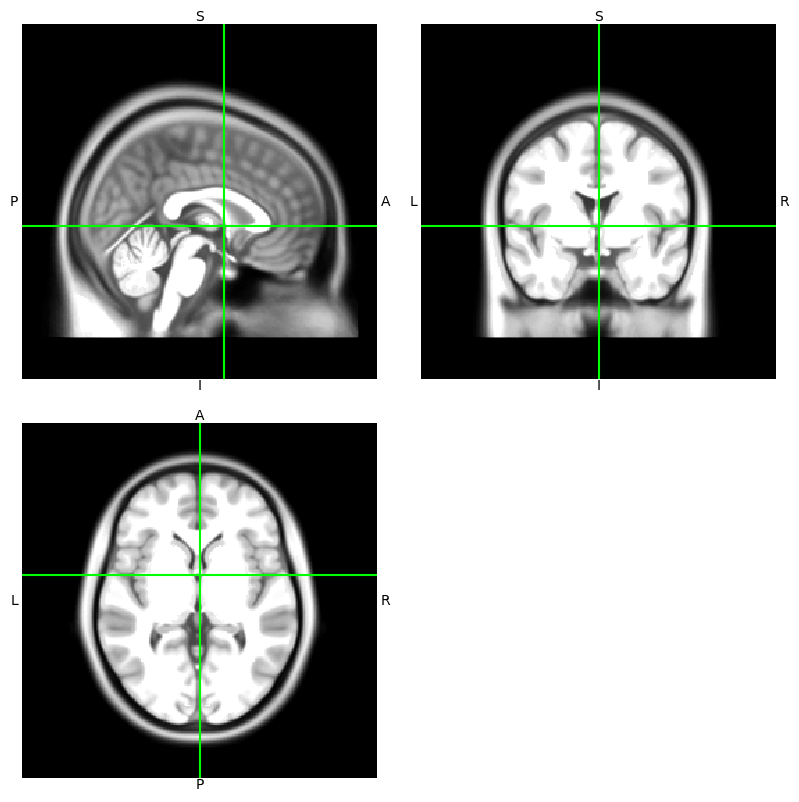

In [30]:
import nibabel as nib
t1mgz = nib.load(f"{CEREBRA_DATA_ICBM152_DIR}/mri/T1.mgz")
inspect_img(f"{CEREBRA_DATA_ICBM152_DIR}/mri/T1.mgz")

In [34]:
mri_ras_t,vox_ras_t,vox_mri_t

(<Transform | MRI (surface RAS)->RAS (non-zero origin)>
 [[ 1.      0.      0.      0.0005]
  [ 0.      1.      0.     -0.0175]
  [ 0.      0.      1.      0.0185]
  [ 0.      0.      0.      1.    ]],
 <Transform | MRI voxel->RAS (non-zero origin)>
 [[-0.001   0.      0.      0.1285]
  [ 0.      0.      0.001  -0.1455]
  [ 0.     -0.001   0.      0.1465]
  [ 0.      0.      0.      1.    ]],
 <Transform | MRI voxel->MRI (surface RAS)>
 [[-0.001  0.     0.     0.128]
  [ 0.     0.     0.001 -0.128]
  [ 0.    -0.001  0.     0.128]
  [ 0.     0.     0.     1.   ]])

In [32]:
t1mgz.affine

array([[  -1. ,    0. ,    0. ,  128.5],
       [   0. ,    0. ,    1. , -145.5],
       [   0. ,   -1. ,    0. ,  146.5],
       [   0. ,    0. ,    0. ,    1. ]])

In [5]:
bem_model = mne.make_bem_model(
    subject=NEW_SUBJECT_NAME,
    ico=4,
    conductivity=(0.33, 0.0042, 0.33),
    subjects_dir=FS_SUBJECTS_DIR,
)


Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
outer skin  CM is  -0.63  -2.93 -12.47 mm
outer skull CM is  -0.63  -2.89 -12.72 mm
inner skull CM is  -0.67  -3.85  -8.54 mm
Checking that surface outer skull is inside surface outer skin  ...
Checking that surface inner skull is inside surface outer skull ...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    2.0 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    2.4 mm
Surfaces passed the basic topology checks.
Complete.



In [10]:
bem = mne.make_bem_solution(bem_model)

Three-layer model surfaces loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        outer skin  (2562) -> outer skin  (2562) ...


        outer skin  (2562) -> outer skull (2562) ...
        outer skin  (2562) -> inner skull (2562) ...
        outer skull (2562) -> outer skin  (2562) ...
        outer skull (2562) -> outer skull (2562) ...
        outer skull (2562) -> inner skull (2562) ...
        inner skull (2562) -> outer skin  (2562) ...
        inner skull (2562) -> outer skull (2562) ...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
IP approach required...
    Matrix coefficients (homog)...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix (homog)...
    Modify the original solution to incorporate IP approach...
        Combining...
        Scaling...
Solution ready.
BEM geometry computations complete.


In [13]:
vol_src_space_transforms = mne.setup_volume_source_space(
    subject=NEW_SUBJECT_NAME
) 

Sphere                : origin at (0.0 0.0 0.0) mm
              radius  : 95.0 mm
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : /home/carlos/Datasets/subjects/icbm152/mri/T1.mgz

Reading /home/carlos/Datasets/subjects/icbm152/mri/T1.mgz...

Setting up the sphere...
Surface CM = (   0.0    0.0    0.0) mm
Surface fits inside a sphere with radius   95.0 mm
Surface extent:
    x =  -95.0 ...   95.0 mm
    y =  -95.0 ...   95.0 mm
    z =  -95.0 ...   95.0 mm
Grid extent:
    x = -100.0 ...  100.0 mm
    y = -100.0 ...  100.0 mm
    z = -100.0 ...  100.0 mm
68921 sources before omitting any.
28647 sources after omitting infeasible sources not within 0.0 - 95.0 mm.
24303 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.
Source space : MRI voxel -> MRI (surface RAS)
     0.005000  0.000000  0.000000    -100.00 mm
     0.000000  0.005000  0.000000    -100.00 mm
     0.00000

In [21]:
vol_src_space_transforms[0]["mri_ras_t"]

<Transform | MRI (surface RAS)->RAS (non-zero origin)>
[[ 1.      0.      0.      0.0005]
 [ 0.      1.      0.     -0.0175]
 [ 0.      0.      1.      0.0185]
 [ 0.      0.      0.      1.    ]]

In [12]:
bem.keys()

dict_keys(['is_sphere', 'surfs', 'sigma', 'source_mult', 'field_mult', 'gamma', 'nsol', 'solution', 'bem_method', 'solver'])

In [8]:
bem_model[0]

{'id': 4 (FIFFV_BEM_SURF_ID_HEAD),
 'sigma': 0.33,
 'np': 2562,
 'ntri': 5120,
 'coord_frame': 5,
 'rr': array([[-0.00073984, -0.00331891,  0.08369319],
        [ 0.0786732 , -0.00328157,  0.03011615],
        [ 0.02689834,  0.08033116,  0.03537355],
        ...,
        [ 0.00684913,  0.00906104, -0.09696281],
        [ 0.00054144,  0.01090568, -0.09556898],
        [ 0.00199144,  0.00485238, -0.09737741]]),
 'nn': array([[-1.41976393e-05,  1.38905590e-18,  1.00000000e+00],
        [ 8.94547443e-01,  0.00000000e+00,  4.46973010e-01],
        [ 2.76442723e-01,  8.50701266e-01,  4.47086991e-01],
        ...,
        [ 9.06305003e-02,  1.47212416e-01, -9.84943966e-01],
        [ 1.32152692e-02,  1.72348009e-01, -9.84947471e-01],
        [ 3.46996163e-02,  1.06791635e-01, -9.93675744e-01]]),
 'tris': array([[   0,  644,  642],
        [ 642,  643,  162],
        [ 644,  643,  642],
        ...,
        [2561, 2201,  557],
        [2477, 2201, 2561],
        [2477,   11, 2201]], dtype=int3